<a href="https://colab.research.google.com/github/ksairos/tf-advanced-techniques-course/blob/main/course_4/C4_W2_Labs_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 1: Simple AutoEncoder for MNIST dataset

## Imports

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

## Prepare Dataset

### Image preprocessing function

In [ ]:
def map_image(image, label):
  '''Normalizes and flattens the image. Returns image as input and label.'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  image = tf.reshape(image, shape=(784,))

  return image, image

### Load data using TFDS

In [ ]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

## Build a simple model

In [ ]:
def simple_autoencoder(inputs):
  '''Builds the encoder and decoder using Dense layers.'''
  encoder = tf.keras.layers.Dense(64, activation='relu')(inputs)
  decoder = tf.keras.layers.Dense(784, activation='relu')(encoder)

  return encoder, decoder

# input 
inputs = tf.keras.layers.Input(shape=(784,))

# encoder and decoder outputs
encoder_output, decoder_output = simple_autoencoder(inputs)

# setup encoder model for visualization
encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_output)

# setup autoencoder
autoencoder_model = tf.keras.Model(inputs=inputs, outputs=decoder_output)

### Compile the model

In [ ]:
autoencoder_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy'
)

### Train the model

In [ ]:
train_steps = 60000 // BATCH_SIZE
history = autoencoder_model.fit(train_dataset, steps_per_epoch=train_steps, epochs=50)

### Display sample results

In [14]:
# Utility functions

def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,8)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15,5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)  
  display_one_row(disp_predicted, 20, shape=(28,28,))

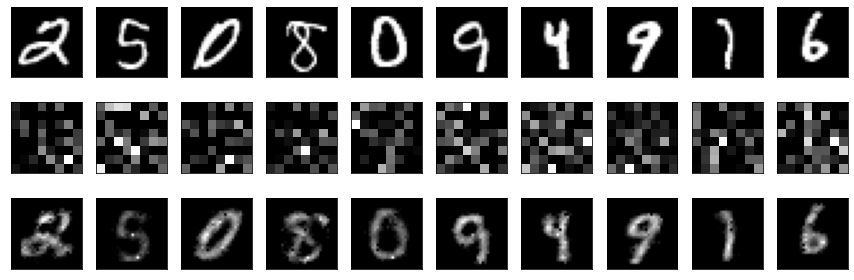

In [ ]:
# take 1 batch of the test dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
  output_samples = input_image

# pick 10 random numbers to be used as indices to the list above
idxs = np.random.choice(BATCH_SIZE, size=10)

# get the encoder output
encoded_pred = encoder_model.predict(test_dataset)

# get a prediction for a test batch
autoencoder_pred = autoencoder_model.predict(test_dataset)

# display 10 samples, encoding and decoding values
display_results(output_samples[idxs], encoded_pred[idxs], autoencoder_pred[idxs])

# Lab 2: Deep AutoEncoder for MNIST dataset

## Build the model

In [ ]:
def deep_autoencoder(inputs):
  '''Builds the encoder and decoder using Dense layers.'''
  encoder = tf.keras.layers.Dense(128, activation='relu')(inputs)
  encoder = tf.keras.layers.Dense(64, activation='relu')(encoder)
  encoder = tf.keras.layers.Dense(32, activation='relu')(encoder)

  decoder = tf.keras.layers.Dense(64, activation='relu')(encoder)
  decoder = tf.keras.layers.Dense(128, activation='relu')(encoder)
  decoder = tf.keras.layers.Dense(784, activation='relu')(encoder)

  return encoder, decoder

# input 
inputs = tf.keras.layers.Input(shape=(784,))

# encoder and decoder outputs
encoder_output, decoder_output = deep_autoencoder(inputs)

# setup encoder model for visualization
deep_encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_output)

# setup autoencoder
deep_autoencoder_model = tf.keras.Model(inputs=inputs, outputs=decoder_output)

In [ ]:
# Compile the model
deep_autoencoder_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy'
)

# Train the model
train_steps = 60000 // BATCH_SIZE
history = deep_autoencoder_model.fit(train_dataset, steps_per_epoch=train_steps, epochs=50)

### Visualize results

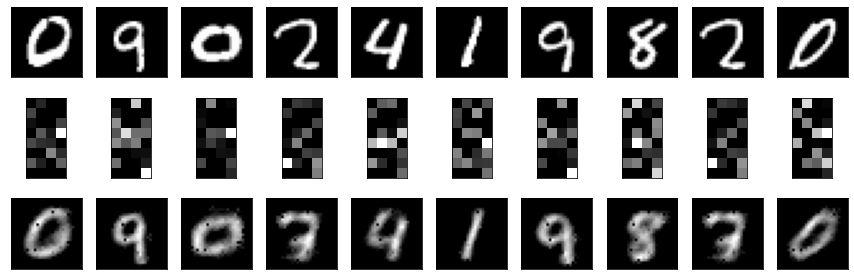

In [ ]:
# take 1 batch of the test dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
  output_samples = input_image

# pick 10 random numbers to be used as indices to the list above
idxs = np.random.choice(BATCH_SIZE, size=10)

# get the encoder output
encoded_pred = deep_encoder_model.predict(test_dataset)

# get a prediction for a test batch
autoencoder_pred = deep_autoencoder_model.predict(test_dataset)

# display 10 samples, encoding and decoding values
display_results(output_samples[idxs], encoded_pred[idxs], autoencoder_pred[idxs], enc_shape=(8, 4))

# Lab 3: Convolutional AutoEncoder for Fashion MNIST dataset

## Prepare dataset

In [ ]:
def map_image(image, label):
  '''Normalizes the image. Returns image as input and label.'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0

  return image, image

In [ ]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

## Define and build the model 

In [6]:
def encoder(inputs):
  '''Defines the encoder with two Conv2D and max pooling layers.'''
  conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(max_pool_1)
  max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

  return max_pool_2

A bottleneck layer is used to get more features but without further reducing the dimension afterwards. Another layer is inserted here for visualizing the encoder output.

In [7]:
def bottleneck(inputs):
  '''Defines the bottleneck.'''
  
  bottleneck = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  encoder_visualization = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(bottleneck) 

  return bottleneck, encoder_visualization

In [8]:
def decoder(inputs):
  '''Defines the decoder path to upsample back to the original image size.'''
  conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  up_sample_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(up_sample_1)
  up_sample_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2)

  conv_3 = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(up_sample_2)

  return conv_3

Time to build the entire model

In [9]:
def conv_auto_encoder():
  ''' Build an entire autoencoder model '''
  inputs = tf.keras.layers.Input(shape=(28, 28, 1))
  encoder_output = encoder(inputs)
  bottleneck_output, encoder_viz_output = bottleneck(encoder_output)
  decoder_output = decoder(bottleneck_output)

  model = tf.keras.Model(inputs=inputs, outputs=decoder_output)
  encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_viz_output)

  return model, encoder_model

In [10]:
conv_autoencoder_model, conv_encoder_model = conv_auto_encoder()
conv_autoencoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)         295168

## Compile and train the model

In [ ]:
train_steps = 60000 // BATCH_SIZE
valid_steps = 60000 // BATCH_SIZE

conv_autoencoder_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy'
)
history = conv_autoencoder_model.fit(train_dataset, steps_per_epoch=train_steps,
                                     validation_data=test_dataset, validation_steps=valid_steps,
                                     epochs=40)

## Visualize Sample results

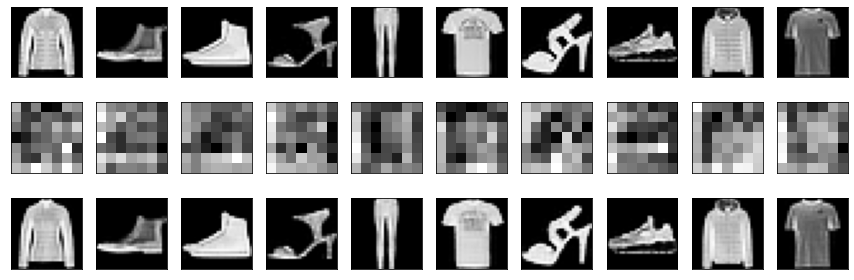

In [ ]:
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 28, 28, 1))

# get the encoder ouput
encoded = conv_encoder_model.predict(conv_output_samples)

# get a prediction for some values in the dataset
predicted = conv_autoencoder_model.predict(conv_output_samples)

# display the samples, encodings and decoded values!
display_results(conv_output_samples, encoded, predicted, enc_shape=(7,7))

# Lab 4: Denoising Images with Convolutional AutoEncoder

In [4]:
def map_image_with_noise(image, label):
  '''Normalizes the images and generates noisy inputs.'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  
  noise_factor = 0.5
  factor = noise_factor * tf.random.normal(shape=image.shape)
  image_noisy = image + factor
  image_noisy = tf.clip_by_value(image_noisy, 0.0, 1.0)
 
  return image_noisy, image

In [ ]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image_with_noise)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image_with_noise)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

We are using the same model as before

In [ ]:
train_steps = 60000 // BATCH_SIZE
valid_steps = 60000 // BATCH_SIZE

conv_autoencoder_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy'
)
history = conv_autoencoder_model.fit(train_dataset, steps_per_epoch=train_steps,
                                     validation_data=test_dataset, validation_steps=valid_steps,
                                     epochs=40)

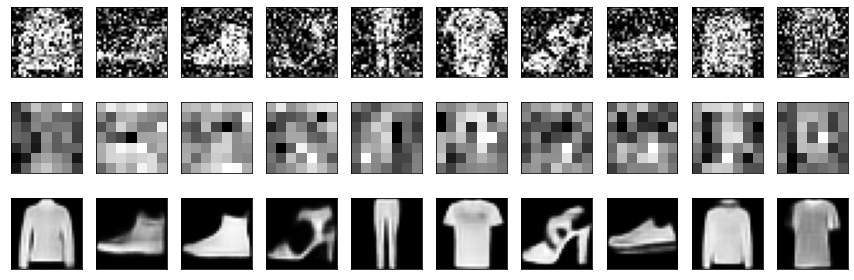

In [15]:
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 28, 28, 1))

# get the encoder ouput
encoded = conv_encoder_model.predict(conv_output_samples)

# get a prediction for some values in the dataset
predicted = conv_autoencoder_model.predict(conv_output_samples)

# display the samples, encodings and decoded values!
display_results(conv_output_samples, encoded, predicted, enc_shape=(7,7))